# DNN BS per convolution output size

Run on Mouse
```
peter@mouse:~/DNNMark$ python run_series.py
Logdir Logdir logs/dnnmark_timings_and_profiles/
...

```

Log files
```
dnn_test_fwd_conv_conv64_bs70.log           - DNNMark stdout + stderr (parse for run time)
dnn_test_fwd_conv_conv64_bs70.log.nvsmi     - nvidia-smi memory usage data
dnn_test_fwd_conv_conv64_bs70_%p.nvprof     - DNNMark stdout (not used)
dnn_test_fwd_conv_conv64_bs70_29096.nvprof  - profiling data (kernels)

dnn_test_bwd_conv_conv64_bs70.log             
dnn_test_bwd_conv_conv64_bs70.log.nvsmi       
dnn_test_bwd_conv_conv64_bs70_%p.nvprof       
dnn_test_bwd_conv_conv64_bs70_22187.nvprof       
```



## Read .log files

In [86]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import lib
import seaborn as sns
import itertools
from cycler import cycler
from random import randint
import math

In [87]:
batch_conv_pattern = re.compile(r"b\s*(\d+)\s+conv\s*([0-9\.]+)")
output_pattern = re.compile(r"Total running time\(ms\): ([0-9\.\e\+]+)")
#filename_pattern=re.compile(r"^dnn_bwd_conv_conv([0-9]+)_bs([0-9]+)\.log$")
filename_pattern=re.compile(r"^dnn_test_([fbwd]+)_conv_conv([0-9]+)_bs([0-9]+)\.log$") 
pars = {
    "batch_conv_pattern": batch_conv_pattern,
    "output_pattern" : output_pattern,
    "filename_pattern" : filename_pattern,
    "columns" : ["f/b","conv","batch"]
}

In [88]:
logdir="logs/dnnmark_timings_and_profiles"
dflog = lib.lib.readLogs(logdir,pars,debug=False)
print dflog.shape
dflog.head()

(168, 4)


,f/b,conv,batch,time
0,bwd,128,10,1.35010
1,bwd,128,100,3.98828
2,bwd,128,120,4.63696
3,bwd,128,140,5.30786
4,bwd,128,160,6.01514


In [89]:
dflog[["batch","conv"]] = dflog[["batch","conv"]].astype(np.int)
# Convert ms to s
dflog["time"] = dflog["time"]/1000
dflog.sort_values(by=["batch","conv"],inplace=True)
dflog.reset_index(drop=True,inplace=True)
dflog.head()

,f/b,conv,batch,time
0,bwd,32,10,0.001208
1,fwd,32,10,0.000118
2,bwd,64,10,0.001245
3,fwd,64,10,0.000156
4,bwd,128,10,0.001350


## Read .nvsmi files

In [90]:
filename_pattern = re.compile(r"^dnn_test_([fbwd]+)_conv_conv(\d+)_bs(\d+)\.log\.nvsmi$")
columns = ["f/b","conv","batch"]

def readNVSMIfiles(logdir,pars):
    filename_pattern = pars["filename_pattern"]
    fix_columns = pars["columns"]
    list_command = "ls -1 "+logdir
    nvsmi_files=[]
    proc = subprocess.Popen(list_command.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            nvsmi_files.append(os.path.abspath(os.path.join(logdir,line)))
#         else:
#             print line,"didnt match pattern",filename_pattern.pattern
    print "Found nvsmi files:",len(nvsmi_files)
    
    columns=["time","GPU","Memory Total (MiB)","Memory Used (MiB)"] + fix_columns
    df_nvsmi = pd.DataFrame(data=None,columns=columns)
    ind = 0 # DataFrame row numebr (index)
    for lf in nvsmi_files:
        logfile = lf.strip(" \n")
        df = pd.read_csv(logfile,names=columns)
        df["Memory Used (MiB)"] = df["Memory Used (MiB)"].astype(np.int)
        # Get MAX from Memory Used values, leave only one row
        df.sort_values(by="Memory Used (MiB)",inplace=True,ascending=False)
        df.reset_index(drop=True,inplace=True)
        df = df.iloc[:1]
        bs = 0
        conv = 0
        bf = ""
        filename = os.path.basename(logfile)
        m = filename_pattern.match(filename)
        if m:
            for i in range(len(fix_columns)):
                df[fix_columns[i]] = m.group(i+1)
            
        else:
            print "no match in ",filename
        if df.shape[0] > 0:
            df_nvsmi = pd.concat([df_nvsmi,df])
    df_nvsmi.reset_index(drop=True,inplace=True)
    df_nvsmi.drop(["time","GPU"],axis=1,inplace=True)
    try:
        df_nvsmi[["batch","conv","Memory Total (MiB)", "Memory Used (MiB)"]] = df_nvsmi[["batch","conv","Memory Total (MiB)", "Memory Used (MiB)"]].astype(np.int)
    except Exception as e:
        print e.message
    df_nvsmi.sort_values(by=["batch","conv"],inplace=True,ascending=True)
    df_nvsmi.reset_index(drop=True,inplace=True)
    return df_nvsmi

pars = {"columns":columns,
        "filename_pattern":filename_pattern }
df_nvsmi = readNVSMIfiles(logdir,pars)
print df_nvsmi.shape
df_nvsmi.head()

Found nvsmi files: 168
(168, 5)


,Memory Total (MiB),Memory Used (MiB),f/b,conv,batch
0,5058,608,bwd,32,10
1,5058,608,fwd,32,10
2,5058,614,bwd,64,10
3,5058,614,fwd,64,10
4,5058,618,bwd,128,10


## Merge log and nvsmi dataframes

In [91]:
dfmerg = pd.merge(dflog,df_nvsmi,on=["batch","conv","f/b"],how='inner')
dfmerg.sort_values(by=["batch","conv"],ascending=True,inplace=True)
dfmemF = dfmerg[dfmerg["f/b"]=="fwd"].pivot(index="batch",columns="conv",values="Memory Used (MiB)")
dfmemF["Memory Total(MiB)"] = dfmerg.loc[0,"Memory Total (MiB)"]
dfmemB = dfmerg[dfmerg["f/b"]=="bwd"].pivot(index="batch",columns="conv",values="Memory Used (MiB)")
dfmemB["Memory Total(MiB)"] = dfmerg.loc[0,"Memory Total (MiB)"]
dfmemF.head()

conv,32,64,128,256,Memory Total(MiB)
batch,,,,,
10,608,614,618,624,5058
20,612,618,626,640,5058
40,618,628,644,678,5058
60,622,636,664,714,5058
80,626,644,680,750,5058


## Plot times and memory

In [92]:
dfmerg.head()

,f/b,conv,batch,time,Memory Total (MiB),Memory Used (MiB)
0,bwd,32,10,0.001208,5058,608
1,fwd,32,10,0.000118,5058,608
2,bwd,64,10,0.001245,5058,614
3,fwd,64,10,0.000156,5058,614
4,bwd,128,10,0.001350,5058,618


In [93]:
dfconvsF = dflog[dflog["f/b"]=="fwd"].pivot(columns="conv",index="batch",values="time")
dfconvsB = dflog[dflog["f/b"]=="bwd"].pivot(columns="conv",index="batch",values="time")
dfconvsF.head()

conv,32,64,128,256
batch,,,,
10,0.000118,0.000156,0.000305,0.000427
20,0.000168,0.000257,0.000534,0.000770
40,0.000250,0.000481,0.000830,0.001456
60,0.000338,0.000602,0.001234,0.002134
80,0.000428,0.000878,0.001525,0.002818


In [94]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

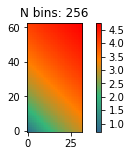

In [95]:
colors1 = getColorList("viridis",4)
colors2 = getColorList("autumn_r",3)
colors = colors1[1:-1] + colors2[1:]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

In [96]:
from matplotlib.ticker import MultipleLocator

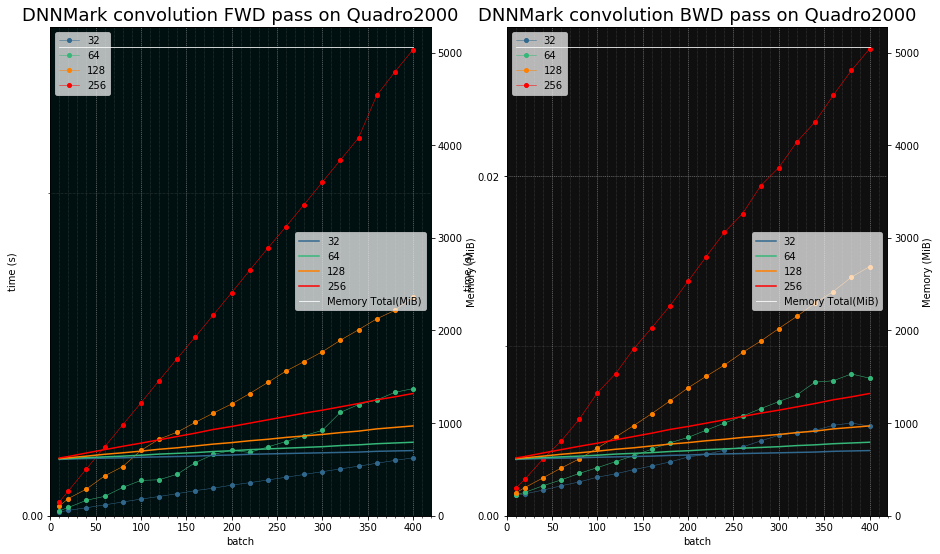

In [97]:
fig,ax = plt.subplots(1,2,figsize=(15,9))
dfconvsF.plot(lw=0.5,marker="o",ms=4,alpha=1,fillstyle="full",ax=ax[0])
ax[0].set_title("DNNMark convolution FWD pass on Quadro2000",fontsize=18)
ax1 = ax[0].twinx()
dfmemF.iloc[:,:-1].plot(lw=1.5,ax=ax1)
dfmemF.iloc[:,-1].plot(lw=.8,ax=ax1,c="w")
ax1.set_ylim(0,None)
ax[0].set_ylim(0,None)

dfconvsB.plot(lw=0.5,marker="o",ms=4,alpha=1,fillstyle="full",ax=ax[1])
ax[1].set_title("DNNMark convolution BWD pass on Quadro2000",fontsize=18)
ax2 = ax[1].twinx()
dfmemB.iloc[:,:-1].plot(lw=1.5,ax=ax2)
dfmemB.iloc[:,-1].plot(lw=.8,ax=ax2,c="w")
ax2.set_ylim(0,None)



def gridAndLabel(ax,ax1):
    ax.grid(ls=":",alpha=.6)
    ax.set_ylabel("time (s)")
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    minorLocatorX = MultipleLocator(10)    
    majorLocatorX = MultipleLocator(50)
    minorLocatorY = MultipleLocator(0.01)
    majorLocatorY = MultipleLocator(0.02)
    ax.xaxis.set_major_locator(majorLocatorX)
    ax.xaxis.set_minor_locator(minorLocatorX)
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.yaxis.set_major_locator(majorLocatorY)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.5)
    ax.legend(framealpha=.7)
    ax1.set_ylabel("Memory (MiB)")
    ax1.legend(framealpha=.7,loc='center right')
    
gridAndLabel(ax[0],ax1)
gridAndLabel(ax[1],ax2)
ax[0].set_facecolor("#000f0f")
ax[1].set_facecolor("#0f0f0f")

## Read nvprof files

In [98]:
# batch_sizes - list of valid batch sizes to read.
# Though target program may have crashed, nvprof file will still be created and have some information,
# but we don't want to see it.
def read_nvprofs(logdir,filename_pattern,batch_sizes):
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))

    print "Have",len(files),"files"
    nvprof  = None
    for fl in files:
        fname = os.path.basename(fl)
        m = filename_pattern.match(fname)
        conv = 0
        batch = 0
        fb = ""
        if m:
            fb = m.group(1)
            conv  = m.group(2)
            batch = m.group(3)
            #print fname,"conv=",conv,"batch=",batch
        else:
            print "not matched:",fname
            break
            
        # Check if batch in the list of batch_sizes to read
        try:
            batch = int(batch)
            conv = int(conv)
        except:
            print "Not parsable bs {} or conv size from file name {}".format(batch, conv, fname)
            
        valid_bs = batch_sizes[conv]
        if batch not in valid_bs:
            #print "-{}/{}".format(batch,conv),
            continue
        
        try:
            nvprof1 = pd.read_csv(fl, header=[0], skiprows=[0,1,2,4])
        except:
            continue
        if len(nvprof1.index) < 1:
            continue
        nvprof1["batch"] = batch
        nvprof1["conv"] = conv
        nvprof1["f/b"] = fb
        nvprof1.sort_values(by="Time(%)",inplace=True,ascending=False)
        #nvprof1 = nvprof1.head(5)
        if nvprof is None:
            nvprof = nvprof1
        else:
            nvprof = pd.concat([nvprof,nvprof1])
    # Drop rows with NaN in Name columns
    nvprof = nvprof[nvprof["Name"].notna()]
    print nvprof.shape
    return nvprof

In [99]:
batch_sizes = {}
for conv in list(dflog["conv"].unique()):
    df_ = dflog[dflog["conv"] == conv]
    batch_sizes[conv] = list(df_["batch"].unique())
print batch_sizes

{32: [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400], 64: [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400], 128: [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400], 256: [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400]}


In [100]:
logdir="logs/dnnmark_timings_and_profiles"
filename_pattern=re.compile(r"dnn_test_([fbwd]+)_conv_conv(\d+)_bs(\d+)_\d+\.nvprof")
nvprof = read_nvprofs(logdir, filename_pattern, batch_sizes)
nvprof.head()

Have 168 files
(1008, 11)


,Type,Time(%),Time,Calls,Avg,Min,Max,Name,batch,conv,f/b
0,GPU activities,60.266426,0.005920,1.0,0.005920,0.005920,0.005920,"generate_seed_pseudo(unsigned __int64, unsigne...",100,128,bwd
1,GPU activities,16.018919,0.001574,1.0,0.001574,0.001574,0.001574,"void cudnn::detail::dgrad_engine<float, int=12...",100,128,bwd
2,GPU activities,13.793557,0.001355,1.0,0.001355,0.001355,0.001355,"void cudnn::detail::wgrad_alg0_engine<float, i...",100,128,bwd
3,GPU activities,9.729871,0.000956,4.0,0.000239,0.000008,0.000464,"void gen_sequenced<curandStateXORWOW, float, i...",100,128,bwd
4,GPU activities,0.151483,0.000015,1.0,0.000015,0.000015,0.000015,"void scalePackedTensor_kernel<float, float>(cu...",100,128,bwd


### Reorder kernels by aggregated Time

In [101]:
kernels = nvprof[["Time","Name"]]
kernels.sort_values(by="Name").head()

,Time,Name
6,0.000002,[CUDA memcpy HtoD]
3,0.000002,[CUDA memcpy HtoD]
6,0.000002,[CUDA memcpy HtoD]
3,0.000002,[CUDA memcpy HtoD]
3,0.000002,[CUDA memcpy HtoD]


In [102]:
def SquashAndOrder(df):
    ms_= df[["Time","Name"]].groupby(by="Name").sum()
    ms_.sort_values(by="Time",inplace=True,ascending=False)
    ms_.rename(columns={"Time":"Total time"},inplace=True)
    ms_.reset_index(inplace=True)
    ms_["order"] = ms_.index
    return ms_

In [103]:
kernels = SquashAndOrder(kernels)
kernels.sort_values(by="Total time",ascending=False).head()

,Name,Total time,order
0,"generate_seed_pseudo(unsigned __int64, unsigne...",0.993023,0
1,"void cudnn::detail::dgrad_engine<float, int=12...",0.250359,1
2,"void gen_sequenced<curandStateXORWOW, float, i...",0.136223,2
3,void cudnn::detail::implicit_convolve_sgemm<fl...,0.132341,3
4,"void cudnn::detail::wgrad_alg0_engine<float, i...",0.110410,4


[u'#8c564bff', u'#c49c94ff']
20 13


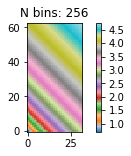

In [104]:
colors1 = getColorList("tab20",20)
print colors1[10:12]
colors1[10] = "#7E975Fff"
colors1[11] = "#D3ECA3ff"

colors = colors1
print len(colors),kernels.shape[0]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

In [105]:
kernels["colors"] = colors[:kernels.shape[0]]
kernels.head()

,Name,Total time,order,colors
0,"generate_seed_pseudo(unsigned __int64, unsigne...",0.993023,0,#1f77b4ff
1,"void cudnn::detail::dgrad_engine<float, int=12...",0.250359,1,#aec7e8ff
2,"void gen_sequenced<curandStateXORWOW, float, i...",0.136223,2,#ff7f0eff
3,void cudnn::detail::implicit_convolve_sgemm<fl...,0.132341,3,#ffbb78ff
4,"void cudnn::detail::wgrad_alg0_engine<float, i...",0.110410,4,#2ca02cff


In [106]:
def addOrderColumn(df,kernels):
    df = pd.merge(df,kernels,on="Name",how="left")
    return df

In [107]:
nvprof_col = addOrderColumn(nvprof,kernels)
nvprof_col.head()

,Type,Time(%),Time,Calls,Avg,Min,Max,Name,batch,conv,f/b,Total time,order,colors
0,GPU activities,60.266426,0.005920,1.0,0.005920,0.005920,0.005920,"generate_seed_pseudo(unsigned __int64, unsigne...",100,128,bwd,0.993023,0,#1f77b4ff
1,GPU activities,16.018919,0.001574,1.0,0.001574,0.001574,0.001574,"void cudnn::detail::dgrad_engine<float, int=12...",100,128,bwd,0.250359,1,#aec7e8ff
2,GPU activities,13.793557,0.001355,1.0,0.001355,0.001355,0.001355,"void cudnn::detail::wgrad_alg0_engine<float, i...",100,128,bwd,0.055149,6,#d62728ff
3,GPU activities,9.729871,0.000956,4.0,0.000239,0.000008,0.000464,"void gen_sequenced<curandStateXORWOW, float, i...",100,128,bwd,0.136223,2,#ff7f0eff
4,GPU activities,0.151483,0.000015,1.0,0.000015,0.000015,0.000015,"void scalePackedTensor_kernel<float, float>(cu...",100,128,bwd,0.002330,10,#7E975Fff


### Make short kernel names

In [108]:
def shortKernels(df):
    df["kernel"] = df["Name"].str.replace("void ","")
    df["kernel"] = df["kernel"].str.replace("cudnn::detail::","")
    df["kernel"] = df["kernel"].str.replace("<"," ")
    df["kernel"] = df["kernel"].str.replace("float","f")
    df["kernel"] = df["kernel"].str.replace("int","i")
    df["kernel"] = df["kernel"].str.replace("bool","b")
    df["kernel"] = df["kernel"].str.replace("=","")
    df["kernel"] = df["kernel"].apply(lambda s: str(s).split(">")[0])
    df[["batch","conv"]] = df[["batch","conv"]].astype(np.int)
    
    df["kernel"] = df["order"].map(str) + " " + df["kernel"]
    return df
nvprof_col = shortKernels(nvprof_col)
nvprof_col.sort_values(by="order",inplace=True,ascending=True)
nvprof_col.head()

,Type,Time(%),Time,Calls,Avg,Min,Max,Name,batch,conv,f/b,Total time,order,colors,kernel
0,GPU activities,60.266426,0.005920,1.0,0.005920,0.005920,0.005920,"generate_seed_pseudo(unsigned __int64, unsigne...",100,128,bwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
315,GPU activities,73.493181,0.005902,1.0,0.005902,0.005902,0.005902,"generate_seed_pseudo(unsigned __int64, unsigne...",140,32,bwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
893,GPU activities,94.981841,0.005980,1.0,0.005980,0.005980,0.005980,"generate_seed_pseudo(unsigned __int64, unsigne...",60,32,fwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
322,GPU activities,70.854245,0.005918,1.0,0.005918,0.005918,0.005918,"generate_seed_pseudo(unsigned __int64, unsigne...",160,32,bwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
329,GPU activities,66.576183,0.005910,1.0,0.005910,0.005910,0.005910,"generate_seed_pseudo(unsigned __int64, unsigne...",180,32,bwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."


### List colors per kernel

In [126]:
def plotKernelsLegend(kernels):
    dfc_ = kernels.copy()
    dfc_["y"] = 1
    size = kernels.shape[0]
    fig,ax = plt.subplots(figsize=(1,size*.4))
    ax1 = ax.twinx()
    for a in [ax,ax1]:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        a.spines["left"].set_visible(False)
        a.spines["bottom"].set_visible(False)
        a.get_yaxis().set_visible(False)
        a.get_xaxis().set_visible(False)
    ax1.yaxis.set_ticks_position('none')
    dfc_["kernel"] = dfc_["order"].map(str) + " " + dfc_["Name"]
    dfc_["kernel"] = dfc_["kernel"].apply(lambda x: x[:150])
    dfc_.sort_values(by="order",ascending=False,inplace=True)
    dfc_.plot.barh(x="kernel",y="y",color=dfc_["colors"].values, width=.75,ax=ax1)
    ax1.legend().set_visible(False)
    plt.show()

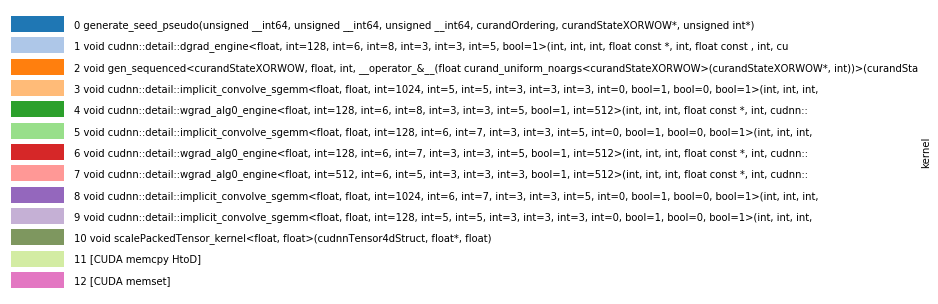

In [127]:
plotKernelsLegend(kernels)

## Plot kernel times

In [111]:
def plotAreaTime(data,values="Time",ax=None):
    df = data.copy()
    df.sort_values(by="order",inplace=True,ascending=True)
    # Use order column to make new columns in the right order
    df = df.pivot_table(index="batch",values=values, columns=["order","kernel"])
    df.columns = df.columns.droplevel()
    df.fillna(0, inplace=True)
    if ax is None:
        fig,ax = plt.subplots(figsize=(5,6))
        
    X = np.asarray(sorted(df.index.unique()))
    Y = np.asarray(df.values)
    Y = np.transpose(Y)
    labels = df.columns.values
    colorlist = []
    for kernel in labels:
        color = str(data[data["kernel"]==kernel]["colors"].values[0])
        colorlist.append(color)
#     for i in range(0,len(labels)):
#         labels[i] = labels[i][:50]
    ax.stackplot(X,Y,labels=labels,colors=colorlist)
    batches = df.index.values    
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    return ax

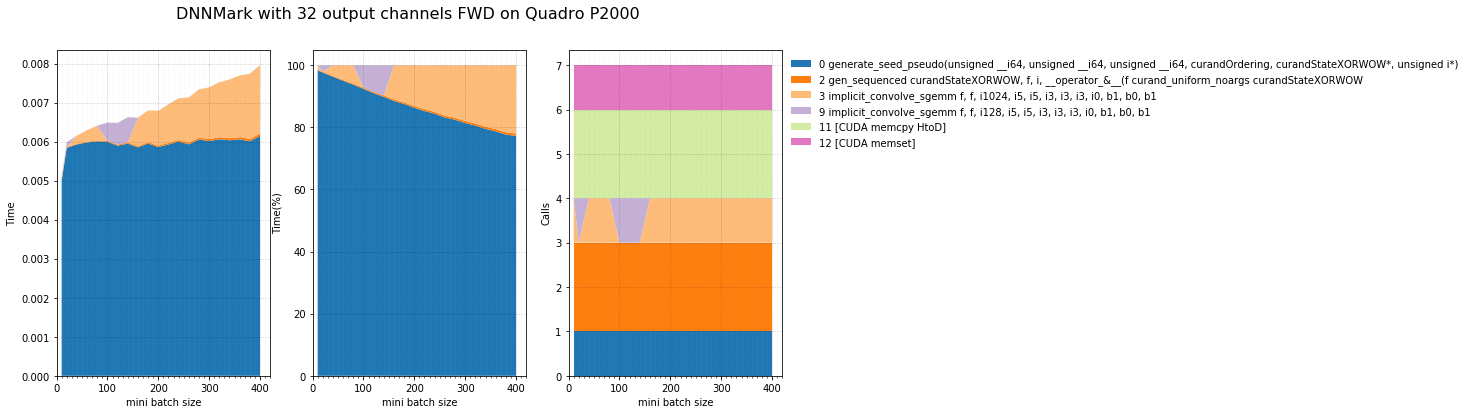

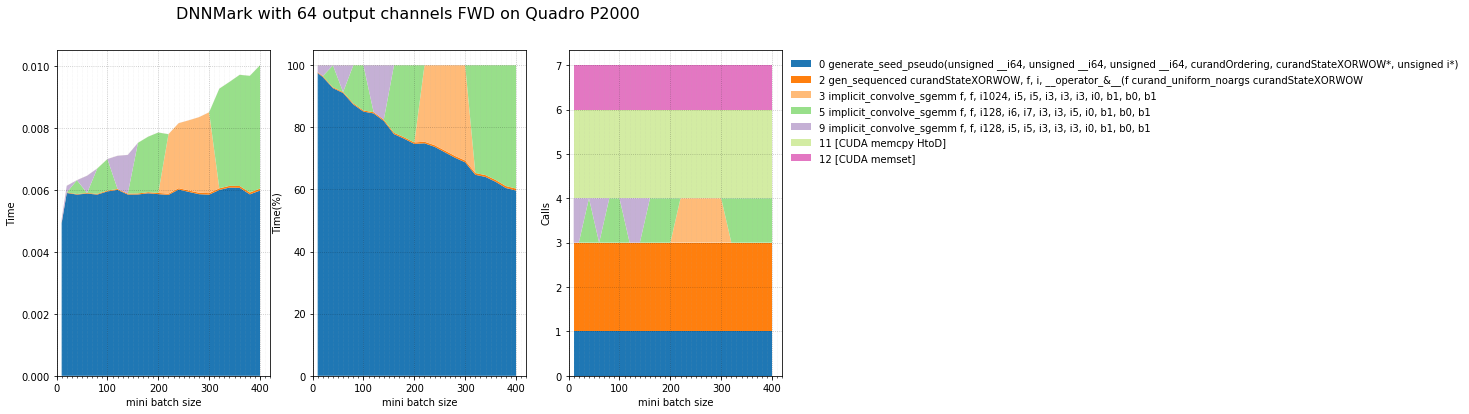

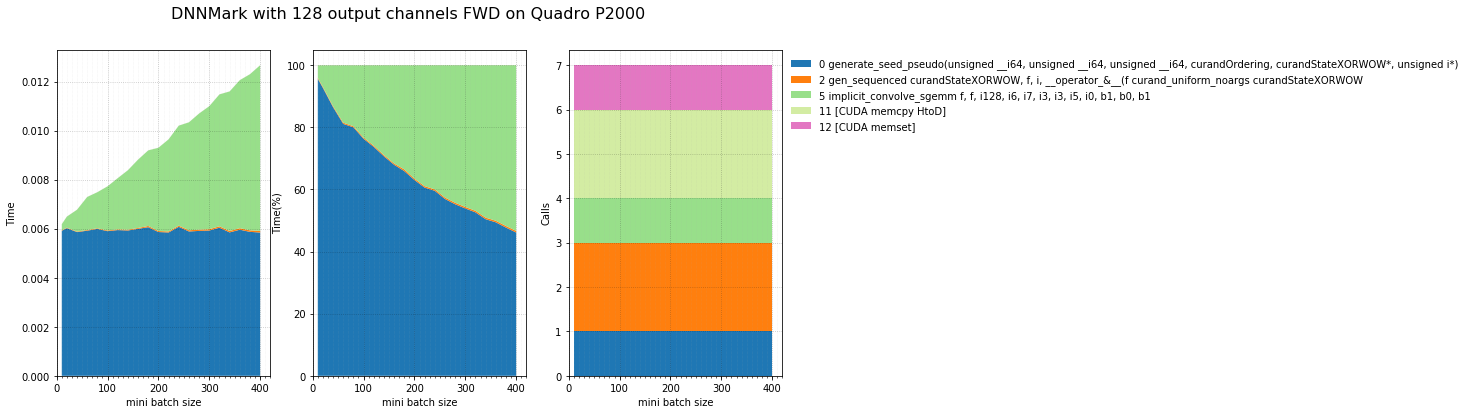

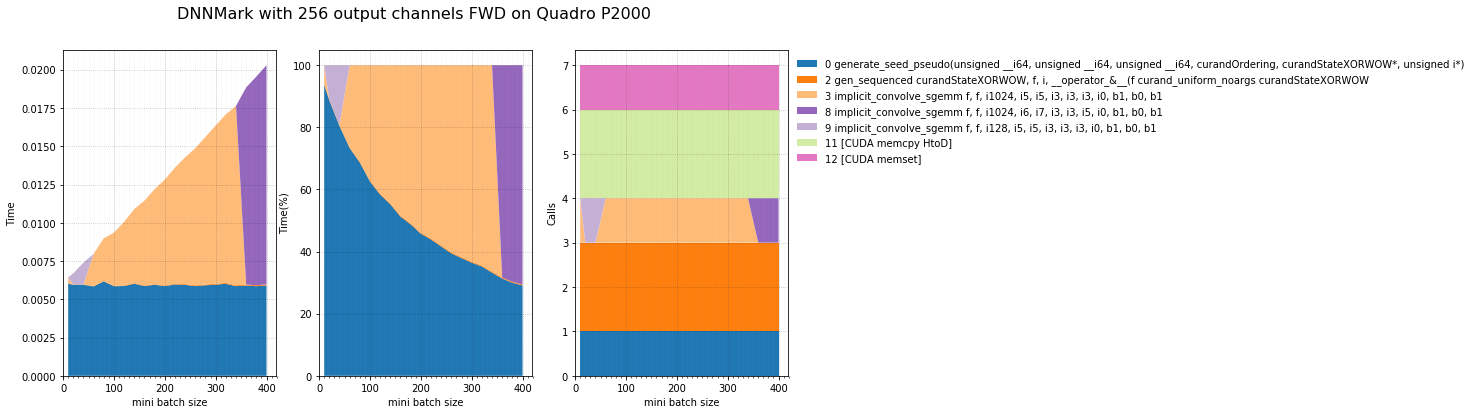

In [112]:
def plotFaceGridTime(df,title=None,values="Time"):
    axes = []
    for conv in sorted(df["conv"].unique()):
        axs = [None]
        if not isinstance(values, list): 
            values = [values]                        
        else:
            if len(values) > 1:
                fig,axs = plt.subplots(1,len(values),figsize=((len(values)-1)*4 + 5,6))
        for i,zz in enumerate(zip(axs,values)):            
            ax = zz[0]
            value = zz[1]
            ax = plotAreaTime(df[df["conv"]==conv],values=value,ax=ax)
            ax.grid(which="major",ls=":",alpha=0.25, color="black")
            minorLocatorX = MultipleLocator(10)
            ax.xaxis.set_minor_locator(minorLocatorX)
            ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.3)
            ax.set_ylabel(value)
            ax.set_xlabel("mini batch size")
            leg = ax.legend(frameon=False, framealpha=0.4,loc='upper left',bbox_to_anchor=(1, 1))
            if i < len(values)-1:
                ax.legend().set_visible(False)
            axes.append(ax)
         
        plt.setp(ax.get_legend().get_texts(), fontsize='10')
        #plt.setp(ax.get_legend().get_texts(), family='Arial Narrow')
        plt.suptitle("DNNMark with {} output channels {}".format(conv,title),fontsize=16)
        plt.show()
    return axes
        
nvprof_fwd = nvprof_col[nvprof_col["f/b"]=="fwd"]
nvprof_bwd = nvprof_col[nvprof_col["f/b"]=="bwd"]
plotFaceGridTime(nvprof_fwd,title="FWD on Quadro P2000",values=["Time","Time(%)","Calls"])
plt.show()

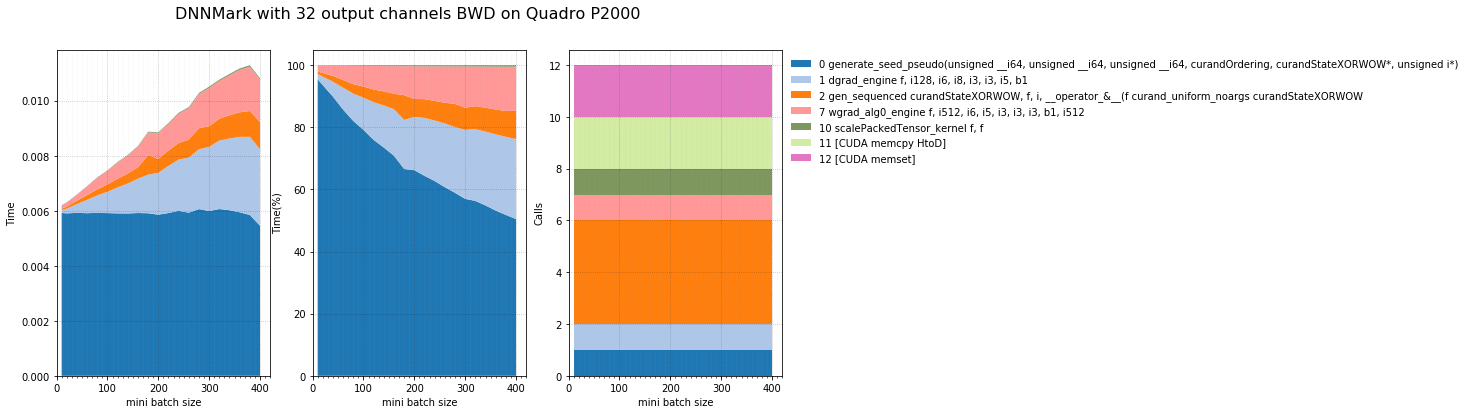

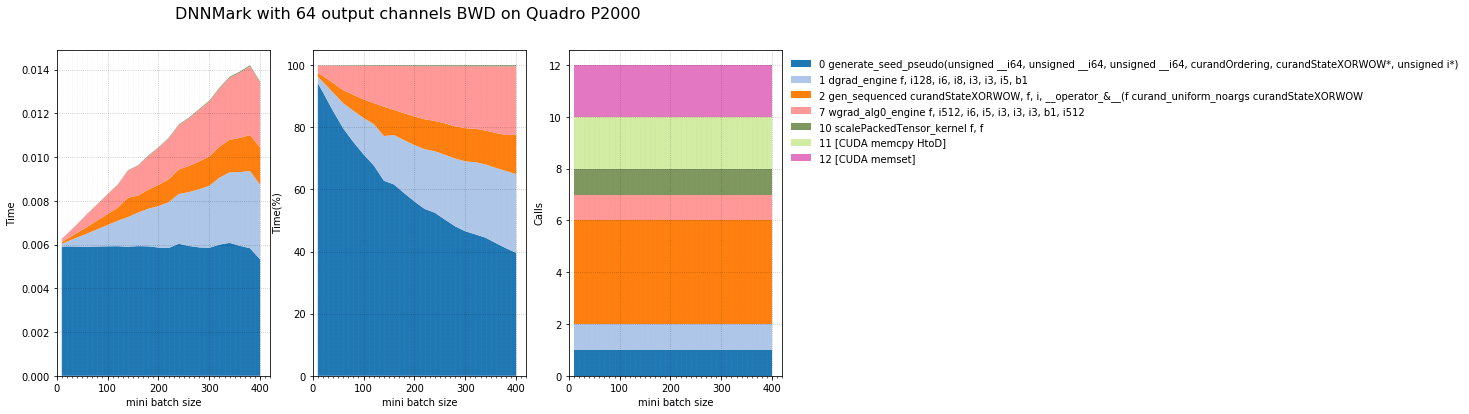

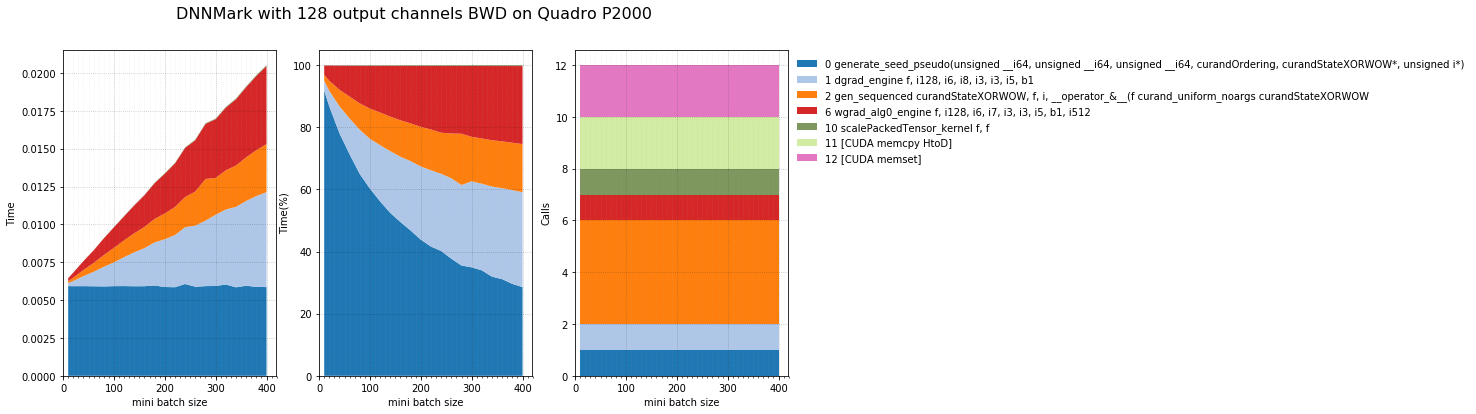

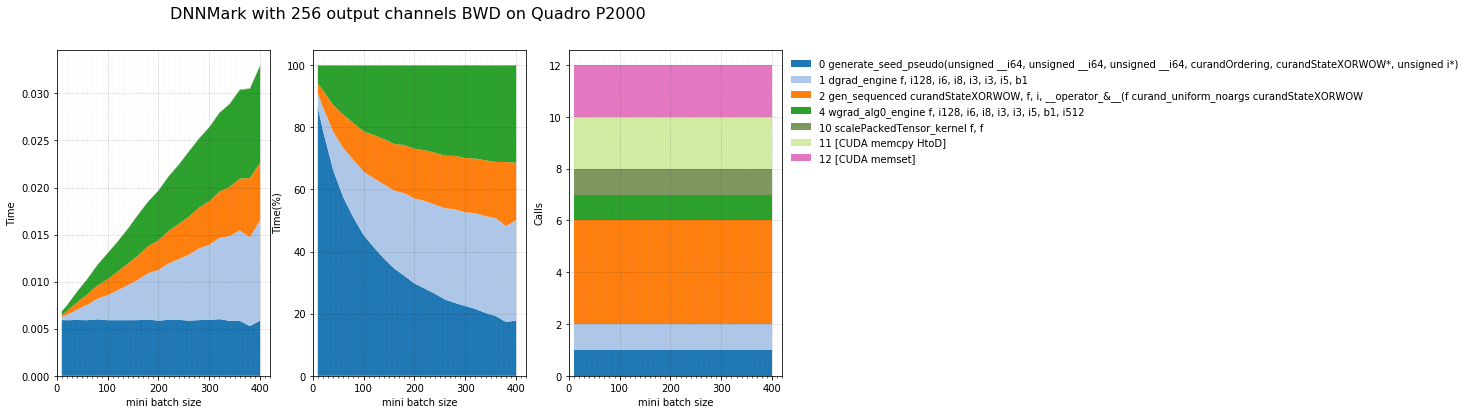

In [113]:
plotFaceGridTime(nvprof_bwd,title="BWD on Quadro P2000",values=["Time","Time(%)","Calls"])
plt.show()

### Kernels distribution

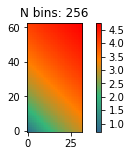

In [114]:
colors1 = getColorList("viridis",4)
colors2 = getColorList("autumn_r",3)
colors = colors1[1:-1] + colors2[1:]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

In [118]:
nvprof_fwd.head()

,Type,Time(%),Time,Calls,Avg,Min,Max,Name,batch,conv,f/b,Total time,order,colors,kernel
893,GPU activities,94.981841,0.005980,1.0,0.005980,0.005980,0.005980,"generate_seed_pseudo(unsigned __int64, unsigne...",60,32,fwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
888,GPU activities,96.289411,0.005928,1.0,0.005928,0.005928,0.005928,"generate_seed_pseudo(unsigned __int64, unsigne...",40,32,fwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
883,GPU activities,77.246921,0.006148,1.0,0.006148,0.006148,0.006148,"generate_seed_pseudo(unsigned __int64, unsigne...",400,32,fwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
878,GPU activities,77.619726,0.006008,1.0,0.006008,0.006008,0.006008,"generate_seed_pseudo(unsigned __int64, unsigne...",380,32,fwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."
873,GPU activities,78.713331,0.006059,1.0,0.006059,0.006059,0.006059,"generate_seed_pseudo(unsigned __int64, unsigne...",360,32,fwd,0.993023,0,#1f77b4ff,"0 generate_seed_pseudo(unsigned __i64, unsigne..."


In [137]:
def plotKernelsDistr_BSxK(df,ax=None,colors=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(7,6))
    if colors is None:
        cp = sns.color_palette(df["colors"].unique())
    else:
        cp = sns.color_palette(colors)
    sns.swarmplot(x="conv",y="batch",hue="kernel",palette=cp,edgecolor="white",linewidth=.7, data=df, dodge=False,s=10,ax=ax)
    minorLocator = MultipleLocator(10)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.grid(ls=":",alpha=.9)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.7)
    ax.set_ylim(0,None)
    ax.legend(bbox_to_anchor=(-0.1, -0.1), loc='upper left',edgecolor="white")


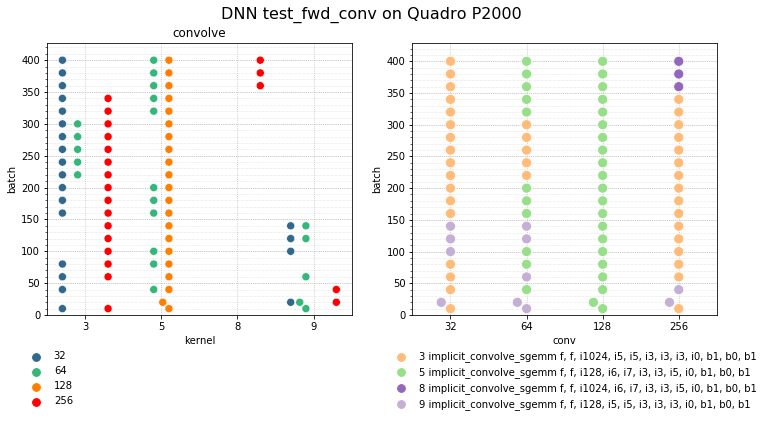

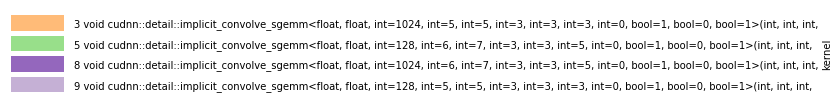

In [140]:
# CAUTION! Takes very long time to plot

def plotKernelsDistr(df,ax=None,colors=None,title=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(7,6))
    if colors is None:
        cp = sns.color_palette(df["colors"].unique())
    else:
        cp = sns.color_palette(colors)
    g = sns.swarmplot(x="order",y="batch",hue="conv",palette=cp,edgecolor="white",linewidth=.5,
                  data=df,dodge=True,s=8,ax=ax)
    minorLocator = MultipleLocator(10)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.set_ylim(0,None)
    ax.grid(ls=":",alpha=.9)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.7)    
    ax.legend().set_visible(False)
    #ax.legend(bbox_to_anchor=(-0.1, -0.1), loc='upper left',edgecolor="white")
    ax.set_xlabel("kernel")
    if title is not None:
        ax.set_title(title)



pattern = r"convolve"
match = nvprof_fwd["Name"].str.contains(pattern)
d1 = nvprof_fwd[match]
# d3 = nvprof_fwd[~match]

# pattern = r"dgrad"
# match = nvprof_col["Name"].str.contains(pattern)
# d2 = d3[match]
# d3 = d3[~match]

fig,axs = plt.subplots(1,2,figsize=(12,5))
plotKernelsDistr(d1,ax=axs[0],colors=colors,title="convolve")
# plotKernelsDistr(d2,ax=axs[1],colors=colors,title="dgrad")
# plotKernelsDistr(d3,ax=axs[2],colors=colors,title="other")
axs[0].legend(bbox_to_anchor=(-.1, -.1), loc='upper left',edgecolor="white")
plotKernelsDistr_BSxK(d1,ax=axs[1])
title = "DNN test_fwd_conv on Quadro P2000"
plt.suptitle(title,fontsize=16)
plt.show()

plotKernelsLegend(kernels[kernels["Name"].str.contains(pattern)])

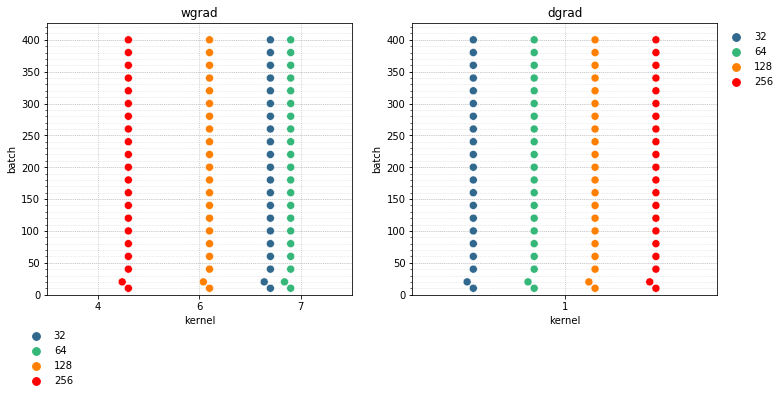

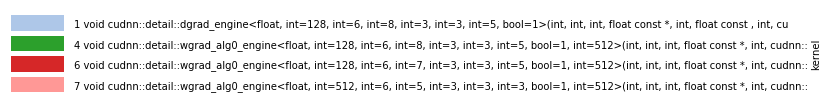

In [136]:
pattern = r"wgrad"
match = nvprof_bwd["Name"].str.contains(pattern)
d1 = nvprof_bwd[match]
d3 = nvprof_bwd[~match]

pattern = r"dgrad"
match = d3["Name"].str.contains(pattern)
d2 = d3[match]
# d3 = d3[~match]

fig,axs = plt.subplots(1,2,figsize=(12,5))
plotKernelsDistr(d1,ax=axs[0],colors=colors,title="wgrad")
plotKernelsDistr(d2,ax=axs[1],colors=colors,title="dgrad")
# plotKernelsDistr(d3,ax=axs[2],colors=colors,title="other")
axs[0].legend(bbox_to_anchor=(-.1, -.1), loc='upper left',edgecolor="white")
axs[1].legend(bbox_to_anchor=(-.1, -.1), loc='upper left',edgecolor="white")
# plotKernelsDistr_BSxK(d1,ax=axs[1])
# title = "DNN test_fwd_conv on Quadro P2000"
# plt.suptitle(title,fontsize=16)
plt.show()

pattern = r"grad"
plotKernelsLegend(kernels[kernels["Name"].str.contains(pattern)])